In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob 
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
img_path = glob.glob("d:/datasets/face_dataset/*.jpg")

In [3]:
len(img_path)

3309

In [4]:
img_path[:5],img_path[-5:]

(['d:/datasets/face_dataset\\202031101020037-f-1.jpg',
  'd:/datasets/face_dataset\\202031101020037-f-10.jpg',
  'd:/datasets/face_dataset\\202031101020037-f-11.jpg',
  'd:/datasets/face_dataset\\202031101020037-f-12.jpg',
  'd:/datasets/face_dataset\\202031101020037-f-13.jpg'],
 ['d:/datasets/face_dataset\\202031113010290-m-6.jpg',
  'd:/datasets/face_dataset\\202031113010290-m-7.jpg',
  'd:/datasets/face_dataset\\202031113010290-m-8.jpg',
  'd:/datasets/face_dataset\\202031113010290-m-9.jpg',
  'd:/datasets/face_dataset\\\x7f202031101020041-m-8.jpg'])

In [5]:
import random
random.shuffle(img_path)

In [6]:
img_path[:5],img_path[-5:]

(['d:/datasets/face_dataset\\202031112050085-m-7.jpg',
  'd:/datasets/face_dataset\\202031101020041-f-11.jpg',
  'd:/datasets/face_dataset\\202031112050025-m- 11.jpg',
  'd:/datasets/face_dataset\\202031112050085-m-2.jpg',
  'd:/datasets/face_dataset\\202031112050032-m-23.JPG'],
 ['d:/datasets/face_dataset\\202031112050051-m-3.jpg',
  'd:/datasets/face_dataset\\202031112050078-f-20.jpg',
  'd:/datasets/face_dataset\\202031112050055-m-6.jpg',
  'd:/datasets/face_dataset\\202031112050049-m-22.jpg',
  'd:/datasets/face_dataset\\202031112050024-f-10.jpg'])

In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[128,128])
    image = tf.cast(image,tf.float32)
    image = image/255.0
    return image

In [8]:
# 移除不能正常解码的图片
img_path_r = []
img_path_e = []
for rr in range(len(img_path)):
    img_path_ = img_path[rr]
    try:
        image = tf.io.read_file(img_path_)
        image = tf.image.decode_jpeg(image,channels=3)
        img_path_r.append(img_path_) # 译码成功，添加到img_path_r
        
    except:
        img_path_e.append(img_path_)

In [9]:
len(img_path_r),len(img_path_e)

(2947, 362)

In [10]:
img_path = img_path_r

In [11]:
all_image_labels = [int(p.replace("-","-").split("-")[1]=="f") for p in img_path]
# f 编码为1，m编码为0

In [12]:
all_image_labels[:5],all_image_labels[-5:]

([0, 1, 0, 0, 0], [0, 1, 0, 0, 1])

In [13]:
path_ds = tf.data.Dataset.from_tensor_slices(img_path[:int(len(img_path)*.85)])
test_ds = tf.data.Dataset.from_tensor_slices(img_path[int(len(img_path)*.85):])

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [15]:
test_image_ds = test_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [16]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:int(len(img_path)*.85)],tf.int64))
test_ds = all_image_labels[int(len(img_path)*.85):]

In [54]:
test_label_ds = all_image_labels[int(len(img_path)*.85):]

In [17]:
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

In [18]:
val_count = int(len(img_path)*.85*.2)
train_count = (int(len(img_path)*.85)) - val_count

In [19]:
val_count,train_count

(500, 2004)

In [20]:
val_data = image_label_ds.take(val_count)
train_data = image_label_ds.skip(val_count)

In [21]:
train_data,val_data

(<SkipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [22]:
BATCH_SIZE = 32

In [23]:
train_data = train_data.repeat()
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

In [25]:
val_data = val_data.batch(BATCH_SIZE)
test_data = test_image_ds.batch(BATCH_SIZE)

In [26]:
train_data,val_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>)

# 建立模型

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(128,128,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 global_average_pooling2d (G  (None, 64)              

In [30]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [32]:
steps_per_epoch = train_count//BATCH_SIZE

In [57]:
history = model.fit(train_data,epochs=70,steps_per_epoch=steps_per_epoch,validation_data=val_data)

Epoch 1/70
62/62 [==============================] - 50s 791ms/step - loss: 0.4798 - acc: 0.7787 - val_loss: 0.4820 - val_acc: 0.7740
Epoch 2/70
62/62 [==============================] - 54s 868ms/step - loss: 0.4756 - acc: 0.7737 - val_loss: 0.4814 - val_acc: 0.7620
Epoch 3/70
62/62 [==============================] - 55s 879ms/step - loss: 0.4616 - acc: 0.7777 - val_loss: 0.4555 - val_acc: 0.8020
Epoch 4/70
62/62 [==============================] - 52s 846ms/step - loss: 0.4598 - acc: 0.7807 - val_loss: 0.5029 - val_acc: 0.7400
Epoch 5/70
62/62 [==============================] - 54s 862ms/step - loss: 0.4502 - acc: 0.7903 - val_loss: 0.4318 - val_acc: 0.8120
Epoch 6/70
62/62 [==============================] - 53s 848ms/step - loss: 0.4395 - acc: 0.8014 - val_loss: 0.4378 - val_acc: 0.7960
Epoch 7/70
62/62 [==============================] - 52s 846ms/step - loss: 0.4430 - acc: 0.7918 - val_loss: 0.5613 - val_acc: 0.7160
Epoch 8/70
62/62 [==============================] - 53s 861ms/step - 

In [58]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

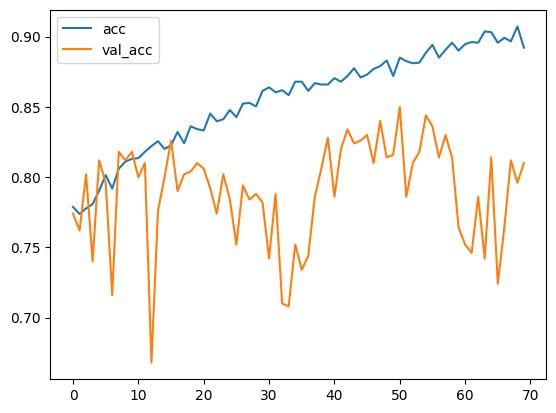

In [59]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')
plt.legend()

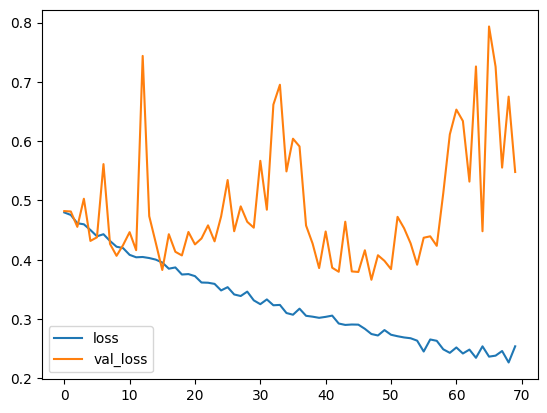

In [60]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')
plt.legend()

In [61]:
pred = model.predict(test_data)

14/14 [==============================] - 2s 121ms/step


In [62]:
pred_ = [int(i>0.5) for i in pred]

In [63]:
print(classification_report(test_label_ds,pred_))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       194
           1       0.81      0.81      0.81       249

    accuracy                           0.79       443
   macro avg       0.78      0.79      0.78       443
weighted avg       0.79      0.79      0.79       443

